### Importing Libraries

In [113]:
import cv2
import os
import tensorflow as tf
import numpy as np
import imageio
from typing import List
from matplotlib import pyplot as plt

#### For memory saving in collab, To prevent exponential memory growth

In [114]:
physical_devices = tf.config.list_physical_devices('CPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

#### Function to load a video from a specified path, preprocess the frames, and return a list of normalized and standardized grayscale frames.


In [115]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    # list for storing images
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:]) #isolating mouth region
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32)) # standard deviation
    return tf.cast((frames - mean), tf.float32) / std

In [116]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [117]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [118]:
# function to convert char list to integers
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
# function to convert integers list to char list
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    "\n"
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] 
(size =40)


#### To load the .align files from the folder for Training purpose


In [119]:
# Our .align files are loaded by this function for preprocessing
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        # for removing the sil (silence) from align file lines.
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [120]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [121]:
test_path = '.\\data\\s1\\swwp2n.mpg'

In [122]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0] 
# just formating the path data (removing \\ and other sub-names)

'swwp2n'

In [123]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

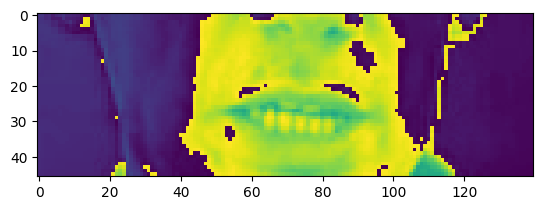

In [130]:
plt.imshow(frames[27])

In [69]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])
# [bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()] >>> will give the transcipted vaue

<tf.Tensor: shape=(), dtype=string, numpy=b'set white with p two now'>

In [70]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

### Data Pipeline for neural network

In [71]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [72]:
frames, alignments = data.as_numpy_iterator().next()

In [73]:
sample = data.as_numpy_iterator()

In [74]:
val = sample.next(); val[0]

array([[[[[ 1.414462  ],
          [ 1.4930432 ],
          [ 1.414462  ],
          ...,
          [ 0.15716244],
          [ 0.11787183],
          [ 0.11787183]],

         [[ 1.414462  ],
          [ 1.4930432 ],
          [ 1.3751713 ],
          ...,
          [ 0.15716244],
          [ 0.11787183],
          [ 0.11787183]],

         [[ 1.3751713 ],
          [ 1.3751713 ],
          [ 1.3751713 ],
          ...,
          [ 0.11787183],
          [ 0.07858122],
          [ 0.07858122]],

         ...,

         [[ 1.0215559 ],
          [ 1.0215559 ],
          [ 0.98226523],
          ...,
          [ 9.861943  ],
          [ 9.861943  ],
          [ 9.861943  ]],

         [[ 1.0215559 ],
          [ 1.0215559 ],
          [ 0.98226523],
          ...,
          [ 9.822653  ],
          [ 9.822653  ],
          [ 9.822653  ]],

         [[ 1.0215559 ],
          [ 1.0215559 ],
          [ 0.98226523],
          ...,
          [ 9.822653  ],
          [ 9.822653  ],
          

In [75]:
#imageio.mimsave('./animation.gif', val[0], 'GIF', duration= 100)
#imageio.mimsave('./animation.gif', val[0][1],'GIF', duration=100) ## not running , 

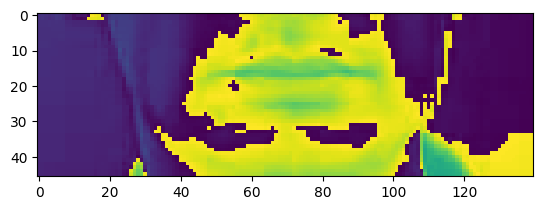

In [76]:
plt.imshow(val[0][0][0]) # 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 

In [77]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s eight sp please'>

## Neural Network

In [78]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [79]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [80]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [81]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [82]:
yhat = model.predict(val[0])

1/1 [==============================] - 5s 5s/step


In [83]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'3ggggg4444444444444444444xxxxxx4444444444444444444444444444444444444444444d'>

In [84]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'3ggggg4444444444444444444xxxxxx4444444444444444444444444444444444444444444d'>

In [85]:
model.input_shape

(None, 75, 46, 140, 1)

In [86]:
model.output_shape

(None, 75, 41)

## Training the dataset

In [87]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

#### defining CTC loss function

In [88]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [89]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [90]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [91]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [92]:
schedule_callback = LearningRateScheduler(scheduler)

In [93]:
example_callback = ProduceExample(test)

In [94]:
#  model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

## Predictions checking

In [95]:
#model.load_weights('models/checkpoint')
from tensorflow.keras.optimizers import legacy

# define your optimizer using legacy optimizer class
optimizer = legacy.Adam()

# compile your model with the legacy optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy')

# load your weights using the legacy optimizer
model.load_weights('models/checkpoint')

In [96]:
test_data = test.as_numpy_iterator()

In [98]:
sample = test_data.next(); sample

(array([[[[[1.3038112 ],
           [1.3038112 ],
           [1.3421586 ],
           ...,
           [0.11504216],
           [0.11504216],
           [0.11504216]],
 
          [[1.3038112 ],
           [1.3038112 ],
           [1.3421586 ],
           ...,
           [0.        ],
           [0.03834739],
           [0.        ]],
 
          [[1.3805059 ],
           [1.3805059 ],
           [1.3805059 ],
           ...,
           [0.        ],
           [0.07669477],
           [0.07669477]],
 
          ...,
 
          [[0.92033726],
           [0.92033726],
           [0.92033726],
           ...,
           [9.586846  ],
           [9.586846  ],
           [9.586846  ]],
 
          [[0.92033726],
           [0.92033726],
           [0.92033726],
           ...,
           [9.625194  ],
           [9.586846  ],
           [9.586846  ]],
 
          [[0.92033726],
           [0.92033726],
           [0.92033726],
           ...,
           [9.625194  ],
           [9.586846  

In [99]:
yhat = model.predict(sample[0])

1/1 [==============================] - 6s 6s/step


In [100]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place blue by i nine soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with t one again'>]

In [101]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [102]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place blue by i nine soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with t one again'>]

## Testing on a random video

In [103]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\swih7s.mpg'))

In [104]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set white in h seven soon'>]

In [105]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 2s 2s/step


In [106]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [108]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set white in h seven soon'>]